This document steps through the process and Python code needed to identify the counties in Florida that contain the St. Andrews Bay Watershed. This document assumes some knowledge of doing GIS work with GeoPandas in Python. If you don't know anything about GeoPandas, you can learn more at  [Geocomputation with R](https://automating-gis-processes.github.io/2016/index.html). This is the online textbook for a course in GIS using GeoPandas from the University of Helsinki.

For more information about programming Python in general, I recommend [Automate the Boring Stuff with Python](https://automatetheboringstuff.com/).

Additionally, I recommend installing the Anaconda distribution of Python, as it will come with MatPlotLib, Pandas, Numpy, and many other useful packages for data science/analysis. You can find the Anaconda distribution of Python at their [website](https://www.anaconda.com/products/distribution).

Finally, this document was created as a Jupyter Notebook. For more information about Jupyter Notebooks, click [here](https://jupyter.org/)

## Loading Packages and Data

The first step is to import some necessary packages:


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

If you have not already installed geopandas and matplotlib, install them using

    conda install geopandas
    conda install matplotlib

in the terminal.

Next, we need to load a GIS file that contains the county boundaries. I prefer the county map with detailed shorelines that can be downloaded by clicking this [link](https://download.fgdl.org/pub/state/countyshore_areas_sep15.zip).

Once downloaded, unzip this folder into a subdirectory in the same folder as this .ipynb file. I created a folder called "mapping_data." for this purpose. We load the counties using the following commands:


In [2]:
counties_file = "mapping_data\countyshore_areas_sep15.shp" #define the name of the file
counties = gpd.read_file(counties_file) #load the file.
#Note that you can also simpy do 
#counties = gpd.read_file("countyshore_areas_sep15.shp")

Next, we examine the first 5 lines of the data to make sure it looks ok.


In [3]:
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,ALAND,AWATER,INTPTLAT,INTPTLON,DESCRIPT,FGDLAQDATE,AUTOID,SHAPE_AREA,SHAPE_LEN,geometry
0,None,None,None,None,WATER,WATER,None,None,None,None,...,0.000000e+00,0.0,None,None,WATER,2015-09-24,1,2.701470e+10,4.507754e+07,"MULTIPOLYGON (((267492.080 663494.650, 267492...."
1,12,053,00295751,12053,HERNANDO,HERNANDO COUNTY,06,H1,G4020,None,...,1.224611e+09,300943246.0,+28.5730426,-082.4662272,HERNANDO,2015-09-24,2,1.265956e+09,5.228369e+05,"MULTIPOLYGON (((551025.130 521907.140, 553442...."
2,12,129,00306912,12129,WAKULLA,WAKULLA COUNTY,06,H1,G4020,533,...,1.570621e+09,334901394.0,+30.1403575,-084.3751122,WAKULLA,2015-09-24,3,1.581877e+09,8.698931e+05,"MULTIPOLYGON (((379858.150 679741.650, 379842...."
3,12,131,00295727,12131,WALTON,WALTON COUNTY,06,H1,G4020,None,...,2.687690e+09,522844944.0,+30.6312106,-086.1766139,WALTON,2015-09-24,4,2.753186e+09,7.321848e+05,"MULTIPOLYGON (((172458.210 778412.420, 172914...."
4,12,127,00306921,12127,VOLUSIA,VOLUSIA COUNTY,06,H1,G4020,422,...,2.851714e+09,858278452.0,+29.0577690,-081.1617920,VOLUSIA,2015-09-24,5,2.923794e+09,2.026974e+06,"MULTIPOLYGON (((696125.960 562367.650, 696123...."


The first row (after the column names) defines the water areas. All the other rows are counties. Let's plot it to make sure it looks right:


<AxesSubplot:>

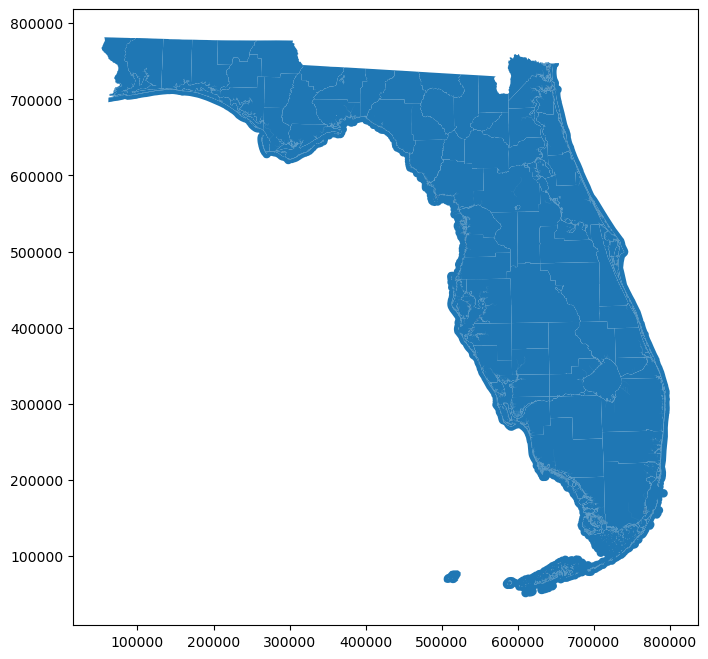

In [4]:
counties.plot(figsize = (10,8))

This is a very basic plot. We can add more bells and whistles later if we want to. We just wanted to make sure all the county boundaries are there. Which it looks like they are.

The next step is to load the watershed data. This was provided by the [Saint Andrew and Saint Joseph Bay Estuary Program](https://pc.fsu.edu/sasjbep). I'll use the same steps as I did in loading the county data.


In [5]:
bay_file = "mapping_data\St_Andrew_Bay_Watershed.shp"

bay = gpd.read_file(bay_file)
#Note again that it's perfectly fine to simply do
#bay = gpd.read_file("St_Andrew_Bay_Watershed.shp")

Again, let's examine the first five rows:


In [6]:
bay.head()

,WATERSHED,SQMILES,ACRES,Label,Shape_Leng,Shape_Area,geometry
0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09,"MULTIPOLYGON (((657728.080 3285899.015, 657752..."


Here we see that this dataset is actually just a single observation. That's fine. All the data we need is contained in the `geometry` column. Let's plot it to see what it looks like:


<AxesSubplot:>

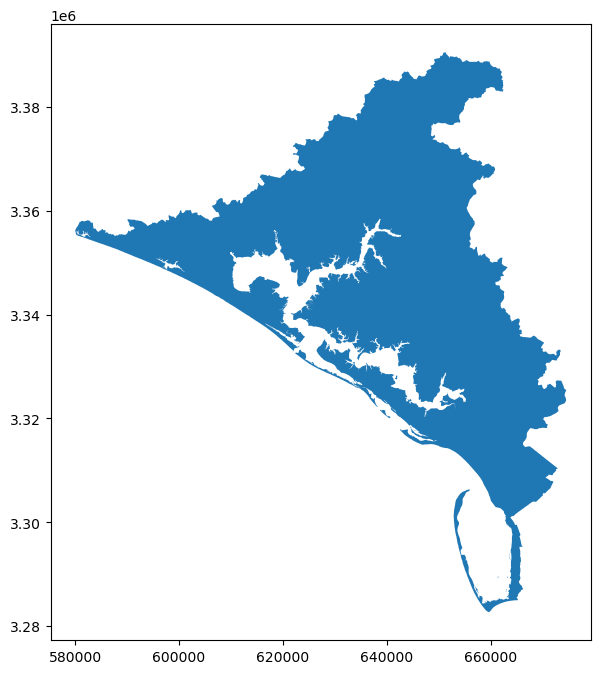

In [7]:
bay.plot(figsize = (10,8))

Again, this plot is very basic, but all we wanted to see is that the watershed appears to be defined correctly.

## Harmonizing Data

Now that we have the two datasets loaded, we need to harmonize their CRS's in order to work with them. A CRS, or coordinate reference system, refers to the way the geometric objects are projected onto a map. For more information on CRS's and working with them in GeoPandas, see [Lesson 3](https://automating-gis-processes.github.io/2016/Lesson3-projections.html) from *Geocomputation with R*.

Let's look at the CRS's of both datasets:


In [8]:
bay.crs

<Projected CRS: EPSG:26916>
Name: NAD83 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 90°W to 84°W and NAD83 by country
- bounds: (-90.0, 23.97, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [9]:
counties.crs

<Projected CRS: PROJCS["Albers Conical Equal Area [Florida Geograp ...>
Name: Albers Conical Equal Area [Florida Geographic Data Library]
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: NAD83 (High Accuracy Reference Network)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

As you can see, they do not use the same projection. Therefore, we'll have to convert one to the other. The easiest way to do this is to change the CRS of the `counties` object.


In [10]:
counties_proj = counties.copy() #create a new dataset that is a copy of counties. 
                                # This allows us to modify the data without affecting the original. 
counties_proj = counties_proj.to_crs(epsg=26916) #change the projection

Let's check the projection of the `counties_proj` object to make sure it matches the watershed.


In [11]:
counties_proj.crs

<Projected CRS: EPSG:26916>
Name: NAD83 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 90°W to 84°W and NAD83 by country
- bounds: (-90.0, 23.97, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

As a final check, we can plot it again to see if it looks right.


<AxesSubplot:>

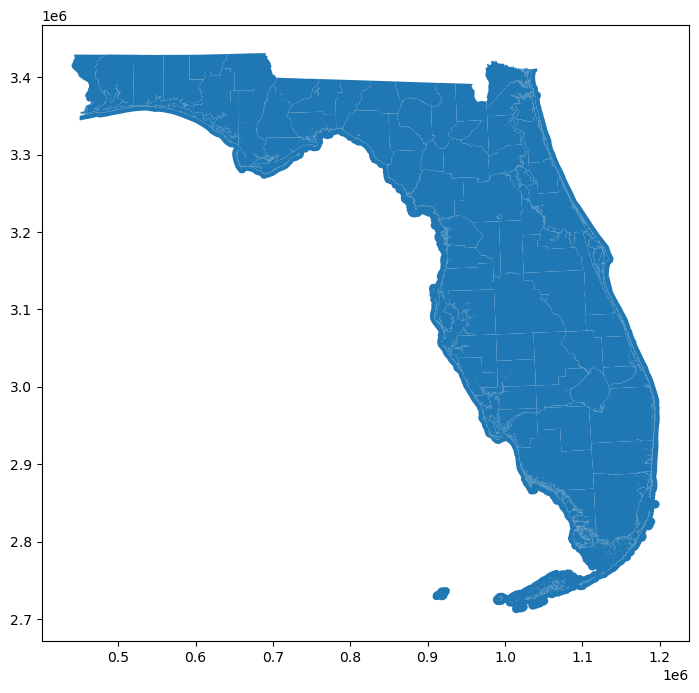

In [12]:
counties_proj.plot(figsize = (10,8))

Seems fine to me.

## Determining the Relevant Counties.

One simple way to determine which counties contain part of the watershed is to simply show them in the same plot.


<AxesSubplot:>

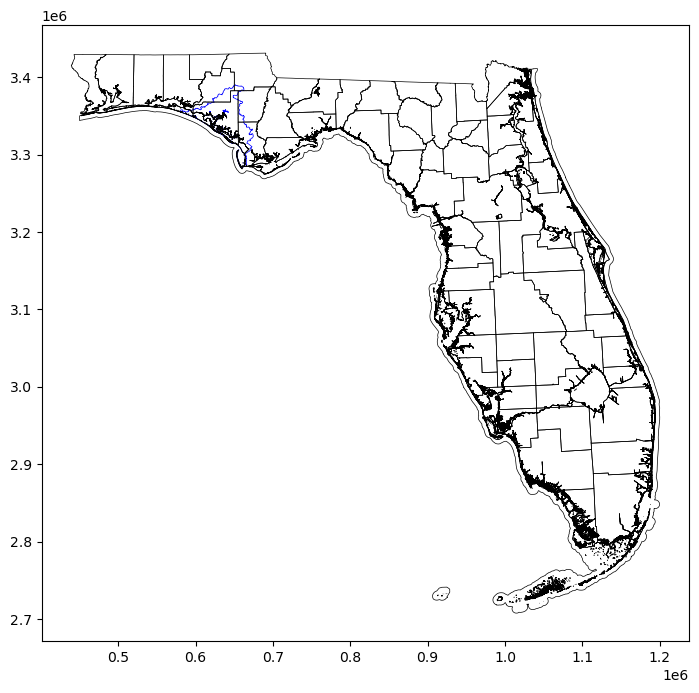

In [13]:
fig, ax = plt.subplots(figsize = (10,8)) #define an emplty plot that we will fill with the two datasets

bay.geometry.boundary.plot(color=None, edgecolor='b', linewidth=0.5, ax=ax) #plot only the watershed borders. No fill.
counties_proj.geometry.boundary.plot(color=None, edgecolor='k', linewidth=0.5, ax=ax) #plot only the county borders. No fill.

It would not be hard at this point to simply look at a county map of Florida and get the names of the counties that contain the watershed. However, since we may want to do some further analysis of the counties and we may want to produce some nicer figures of the bay area, we might as well filter the data to contain only counties that overalp with the watershed.


In [14]:
bay_counties = gpd.sjoin(counties_proj,bay)
bay_counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,SHAPE_AREA,SHAPE_LEN,geometry,index_right,WATERSHED,SQMILES,ACRES,Label,Shape_Leng,Shape_Area
0,None,None,None,None,WATER,WATER,None,None,None,None,...,2.701470e+10,4.507754e+07,"MULTIPOLYGON (((656790.384 3316776.851, 656790...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
3,12,131,00295727,12131,WALTON,WALTON COUNTY,06,H1,G4020,None,...,2.753186e+09,7.321848e+05,"MULTIPOLYGON (((558825.154 3429125.747, 559281...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
18,12,013,00306919,12013,CALHOUN,CALHOUN COUNTY,06,H1,G4020,None,...,1.487458e+09,1.920278e+05,"POLYGON ((680521.151 3387596.693, 680746.153 3...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
33,12,005,00295738,12005,BAY,BAY COUNTY,06,H1,G4020,None,...,1.992719e+09,1.132443e+06,"MULTIPOLYGON (((647799.345 3382670.805, 647815...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
54,12,063,00295734,12063,JACKSON,JACKSON COUNTY,06,H1,G4020,None,...,2.468557e+09,2.267942e+05,"POLYGON ((669268.534 3431030.466, 670890.596 3...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09


Notice that the first observation in this dataset is named "WATER." This is the observation that holds all the water features in Florida. We need to get rid of this observation or any figures we try to produce will contain the whole coastline of Florida. You can try this out by running

    bay_counties.plot()

if you want. So next we'll drop the "WATER" observation:


In [15]:
bay_counties = bay_counties[bay_counties["NAME"] != "WATER"]
bay_counties.head(7)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,SHAPE_AREA,SHAPE_LEN,geometry,index_right,WATERSHED,SQMILES,ACRES,Label,Shape_Leng,Shape_Area
3,12,131,00295727,12131,WALTON,WALTON COUNTY,06,H1,G4020,None,...,2.753186e+09,7.321848e+05,"MULTIPOLYGON (((558825.154 3429125.747, 559281...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
18,12,013,00306919,12013,CALHOUN,CALHOUN COUNTY,06,H1,G4020,None,...,1.487458e+09,1.920278e+05,"POLYGON ((680521.151 3387596.693, 680746.153 3...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
33,12,005,00295738,12005,BAY,BAY COUNTY,06,H1,G4020,None,...,1.992719e+09,1.132443e+06,"MULTIPOLYGON (((647799.345 3382670.805, 647815...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
54,12,063,00295734,12063,JACKSON,JACKSON COUNTY,06,H1,G4020,None,...,2.468557e+09,2.267942e+05,"POLYGON ((669268.534 3431030.466, 670890.596 3...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
58,12,133,00295762,12133,WASHINGTON,WASHINGTON COUNTY,06,H1,G4020,None,...,1.595316e+09,2.404198e+05,"POLYGON ((643879.684 3411685.915, 643992.119 3...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09
64,12,045,00306917,12045,GULF,GULF COUNTY,06,H1,G4020,None,...,1.449020e+09,5.837829e+05,"MULTIPOLYGON (((656790.384 3316776.851, 656779...",0,St. Andrew Bay,1156.573241,740209.835244,4.0,1.315842e+06,2.995523e+09


The "WATER" observation has indeed been dropped.

Let's plot the area again with the watershed superimposed on the counties. This time, I'll add county names. Adding the county names is a somewhat complicated procedure, so I'll step through it carefully. The first thing I need to do is use the `representative_point` method from the `shapely` package. GeoPandas uses the shapely package to manage geometric shapes, so there's no need to load it separately. The `representative_point` method computes a point that is guaranteed to be within a polygon. That's the point at which I will place the county names. I could also use the `centroid` method to find the "center of gravity" of each county, but that method is computationally more expensive, so I will stick with `representative_point`.


In [16]:
#Compute a new variable called 'coords'. The variable is computed by applying the representative point method to each county,
#then extracting the resulting coordinates.
bay_counties['coords'] = bay_counties['geometry'].apply(lambda x: x.representative_point().coords[:])
bay_counties['coords'] = [coords[0] for coords in bay_counties['coords']]


Once I have representative points for each county, the next step is to show the counties and the watershed on the same plot, then add in the names at each representative point in `coords`.


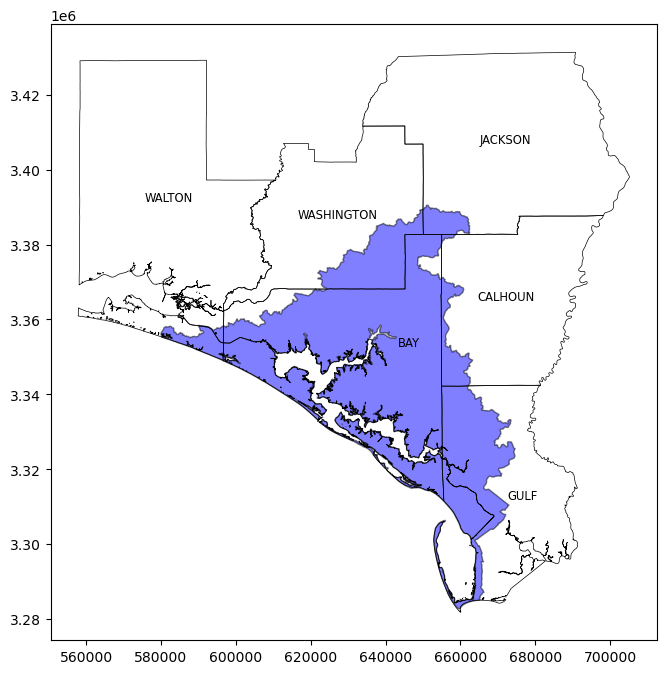

In [17]:
fig, ax = plt.subplots(figsize = (10,8)) #Define an empty figure

bay.plot(color='b', edgecolor='k',alpha=0.5, ax=ax) #Put the watershed boundaries into the empty figure. This time I will use a 
                                                    #transparent blue as a fill.
bay_counties.geometry.boundary.plot(color=None, edgecolor='k', linewidth=0.5, ax=ax) # Plot the county borders

#The for loop below plots the county names at the coordinates specified by the coords variable.
for idx, row in bay_counties.iterrows():
    ax.text(row.coords[0], row.coords[1], s=row['NAME'], size='smaller',
            horizontalalignment='center', bbox={'facecolor':'white', 'alpha':0, 'pad': 2, 'edgecolor':'none'
                                               })

Here we can easily see which counties overlap with the watershed.

Finally, we want to determine how much of the watershed is in each county. In other words, we want to compare the area of the intersection of each county with the watershed with the total area of the watershed. The first step in doing so is to make a new variable for the portion of each county that is part of the watershed.


In [18]:
bay_counties['Watershed'] = bay_counties.geometry.apply(lambda x: x.intersection(bay.geometry[0]))

<AxesSubplot:>

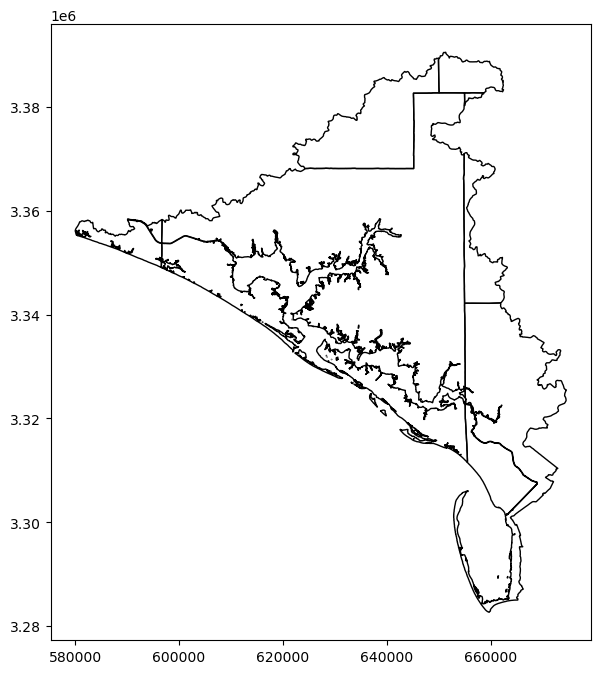

In [19]:
bay_counties['Watershed'].plot(facecolor = "none", edgecolor = 'k', figsize = (10,8))

Next, we make a new variable that calculates the area of the `Watershed` variable. The CRS uses meters as its distance unit, so areas will be in square meters.


In [20]:
bay_counties['Watershed_Area']=bay_counties.Watershed.area

Finally, we make a variable that calculates the percentage of the watershed area in each county:


In [21]:
bay_counties['Watershed_Proportion']=bay_counties.Watershed_Area/bay_counties.Watershed_Area.sum()*100

I can print a table of the percentage of the watershed in each county by selecting the `NAME` and `Watershed_Proportion` columns


In [22]:
bay_counties[['NAME','Watershed_Proportion']]

,NAME,Watershed_Proportion
3,WALTON,2.465263
18,CALHOUN,3.708971
33,BAY,61.935065
54,JACKSON,2.461653
58,WASHINGTON,9.570461
64,GULF,19.858587


Just as a check, we will make sure the percentages add up to 100.


In [23]:
bay_counties.Watershed_Proportion.sum()

100.0

The final task I'd like to accomplish in this document is to export the watershed proportion table to Excel for formatting.


In [24]:
from pandas import ExcelWriter

In [25]:
writer = ExcelWriter("Watershed.xlsx", engine='xlsxwriter')
bay_counties[['NAME', 'Watershed_Area', 'Watershed_Proportion']].to_excel(writer, sheet_name='data',index=False)
writer.save()

A lot more GIS work can be done in Python, and in a future post I hope to introduce some of the other work that is being done on the economic value of the St. Andrew Bay Watershed, but we'll leave it off here for now.